# Import Library

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
from scipy.stats import chi2
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr, spearmanr
import pandas.core.algorithms as algos
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec 
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
max_bin = 20
force_bin = 3
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import  precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score,auc, roc_curve, plot_confusion_matrix, classification_report
from IPython.display import Image
import pydotplus
import matplotlib.pyplot as plt
%matplotlib inline
color = sns.color_palette()
seed = 42

## Data Processing

In [ ]:
#Phân loại cat or num
def cat_num(df):
    cat_feats = [col for col in df.columns if df[col].dtypes == 'object']
    num_feats = [col for col in df.columns if df[col].dtypes != 'object']
    print("number of categorical features: ", len(cat_feats))
    print("number of numeric features: ", len(num_feats))
    Cat_List = {}
    for cat in cat_feats:
        Cat_List[cat] = df[cat].nunique()
    return Cat_List
    
#One-hot Encoding (chỉ encoding giá trị No và Yes), phần categorical feature dựa vào đặc điểm sẽ tự label encoding hoặc tạo biến giá.
from sklearn.preprocessing import LabelEncoder
def encoding(df):
    le = LabelEncoder()
    le_count = 0

    for col in df:
        if df[col].dtype == 'object':
        # If 2 or fewer unique categories
            if len(list(df[col].unique())) <= 2:
                le.fit(df[col])

                df[col] = le.transform(df[col])
                le_count += 1
            
    print('%d columns were label encoded.' % le_count)

    
#Biến giả
def dummies(data):
    data = pd.get_dummies(data)
    return data.shape, data.head()
    

#Correlation
def corr(df1):
    corrmat1= df1.corr().abs()
    upper_tri = corrmat1.where(np.triu(np.ones(corrmat1.shape),k=1).astype(np.bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
    for i in to_drop:
        del df1[i]
    return to_drop, df1.shape

def plot_corr(df1):
  mask = np.triu(df1.corr(), 1)
  plt.figure(figsize=(30, 30))
  sns.heatmap(df1.corr(), annot=True, vmax=1, vmin=-1, square=True, cmap='BrBG', mask=mask)

# Missing data
from sklearn.impute import SimpleImputer
def missing_data(df1):
    number = df1.isnull().sum().sort_values(ascending=False)
    percent = (df1.isnull().sum()/len(df1) * 100).sort_values(ascending=False)

    missing_app_data = pd.concat([number, percent], axis=1, keys=['Number', 'Percentage'])
    return missing_app_data


#woe, iv
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)
    
def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)


def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv) 

def feature_iv(df1,target):
    final_iv, IV = data_vars(df1,target)
    IV = IV[IV['IV'] >= 0.02]
    return IV


#Fill missing data
#value = ['mean', 'median', 'mode',...]
from sklearn.impute import SimpleImputer
def fill_missing(X, value):
    miss_mean_imputer = SimpleImputer(missing_values=np.nan, strategy=value)
    miss_mean_imputer = miss_mean_imputer.fit(X)
    imputed_df = miss_mean_imputer.transform(X.values)
    X =pd.DataFrame(imputed_df)
    return X.info


#resampling
##oversampling
##undersampling
##Combination of over and under-sampling
!conda install -c glemaitre imbalanced-learn
import imblearn

def resampling(method,sub_method,X,y):
    if method == 'over':
        if sub_method == 'ros':
            from imblearn.over_sampling import RandomOverSampler
            ros_ = RandomOverSampler(random_state=0)
            X_res, y_res = ros_.fit_resample(X,y)
            
        elif sub_method == 'smote':
            from imblearn.over_sampling import SMOTE, ADASYN
            X_res, y_res = SMOTE().fit_resample(X,y)
            
        elif sub_method == 'adasyn':
            X_res, y_res = ADASYN().fit_resample(X,y)
            
    elif method == 'under':
        if sub_method == 'rus':
            from imblearn.under_sampling import RandomUnderSampler
            rus_ = RandomUnderSampler(random_state=0)
            X_res, y_res = rus_.fit_resample(X, y)
            
        elif sub_method == 'enn':
            from imblearn.under_sampling import EditedNearestNeighbours
            enn = EditedNearestNeighbours()
            X_res, y_res = enn.fit_resample(X, y)
            
        elif sub_method == 'renn':
            from imblearn.under_sampling import RepeatedEditedNearestNeighbours
            renn = RepeatedEditedNearestNeighbours()
            X_res, y_res = renn.fit_resample(X, y)
            
        elif sub_method == 'allknn':
            from imblearn.under_sampling import AllKNN
            allknn = AllKNN()
            X_res, y_res = allknn.fit_resample(X, y)
            
    elif method == 'combine':
        if sub_method == 'smoteenn':
            from imblearn.combine import SMOTEENN
            smote_enn = SMOTEENN(random_state=0)
            X_res, y_res = smote_enn.fit_resample(X, y)
            
        elif sub_method == 'smotetomek':
            from imblearn.combine import SMOTETomek
            smote_tomek = SMOTETomek(random_state=0)
            X_res, y_res = smote_tomek.fit_resample(X, y)
            
            
    print("After OverSampling, counts of label '1': {}".format(sum(y_res == 1)))
    print("After OverSampling, counts of label '0': {}".format(sum(y_res == 0)))
    return X_res.shape, y_res.shape

#resampling
# umbalanced data
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
def over_sampling(X, y):
  ros = RandomOverSampler(random_state=25)
  X_ros, y_ros = ros.fit_resample(X, y)
  return X_ros, y_ros 
def under_sampling(X, y):
  rus = RandomUnderSampler(random_state = 42, replacement = True)
  X_rus, y_rus = rus.fit_resample(X, y)
  return X_rus, y_rus
def smothing(X, y):
  smote = SMOTE()
  X_smote, y_smote = smote.fit_resample(X, y)
  return X_smote, y_smote

/bin/bash: conda: command not found


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/loan_final313.csv')
df.shape

(887379, 30)

In [ ]:
cat_num(df)

number of categorical features:  10
number of numeric features:  20


{'application_type': 2,
 'grade': 7,
 'home_ownership': 6,
 'income_category': 3,
 'interest_payments': 2,
 'issue_d': 103,
 'loan_condition': 2,
 'purpose': 14,
 'region': 5,
 'term': 2}

### Clean data

In [ ]:
df = df.rename(columns ={'loan_condition_cat' : 'target'})
del_col =['issue_d', 'id', 'grade', 'purpose']
df1 = df.drop(del_col,axis = 1)
encoding(df1)
#Feature Home_ownership: Chuyển NONE và ANY thành OTHER
df1['home_ownership'] = df1['home_ownership'].replace({'NONE':'OTHER', 'ANY': 'OTHER'})

#Feature income_category: encoding theo mức độ.
df1['income_category'] = df1['income_category'].replace({'Low':1, 'Medium': 2, 'High':3})

#Create new features.
df1['LoanAmntOverIncome'] = df1['loan_amount'] / df1['annual_inc']
df1['installmentOverLoanAmnt'] = df1['installment'] / df1['loan_amount']
df1['totalPymntOverIncome'] = df1['total_pymnt'] / df1['annual_inc']
df1['totalRecPrncpOverIncome'] = df1['total_rec_prncp'] / df1['annual_inc']

#Get_dummies
df1 = pd.get_dummies(df1)

4 columns were label encoded.


### Correlation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(['income_cat',
  'term_cat',
  'application_type_cat',
  'interest_payment_cat',
  'target',
  'interest_rate',
  'grade_cat',
  'total_rec_prncp',
  'installment',
  'installmentOverLoanAmnt',
  'totalRecPrncpOverIncome',
  'home_ownership_MORTGAGE',
  'home_ownership_RENT'],
 (887379, 24))

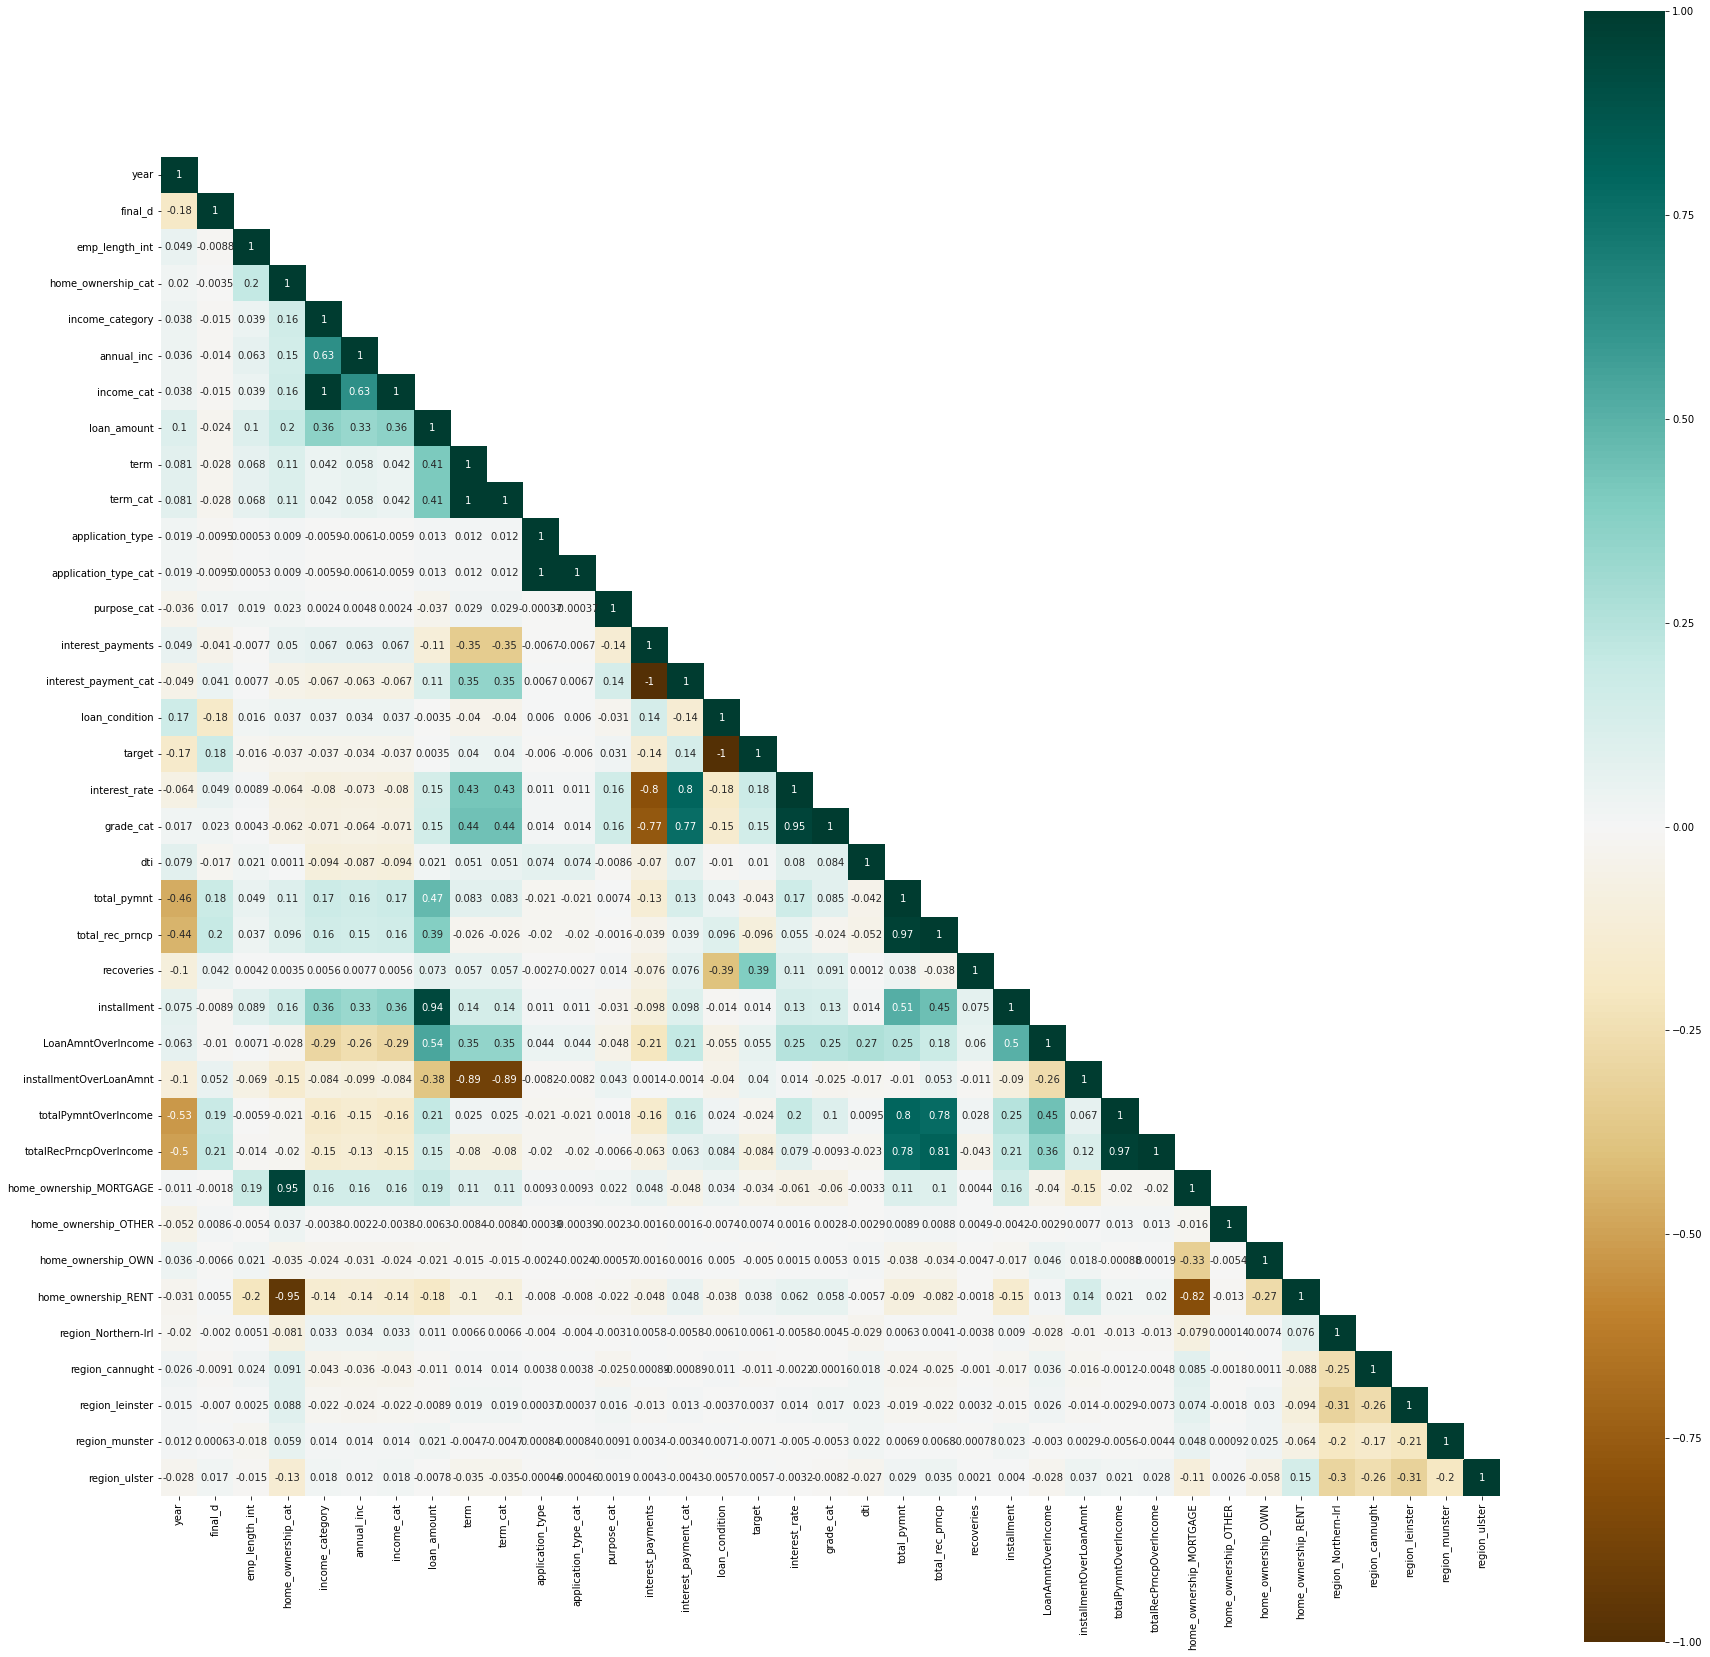

In [ ]:
plot_corr(df1)
corr(df1)

In [ ]:
df1['target'] = df['target']
df1 = df1[np.all(np.isfinite(df1), axis=1)]

In [ ]:
df1.shape

(887377, 25)

### WOE - IV

In [ ]:
feature_iv(df1,df1.target)

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,VAR_NAME,IV
0,LoanAmntOverIncome,0.045766
1,annual_inc,0.046399
5,final_d,1.330527
9,income_category,0.023332
10,interest_payments,0.297842
14,recoveries,0.166742
20,term,0.021293
23,year,0.484092


### Resampling

In [ ]:
X = df1[['LoanAmntOverIncome','annual_inc','final_d','income_category','interest_payments','recoveries','term','year','totalPymntOverIncome']]
y = df1.target

In [ ]:
#resampling('over','smote',X,y)

## Modeling

In [ ]:
#Chia data
from sklearn.model_selection import train_test_split
def split_data(X,y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_val, y_train, y_val

#Scaling data (Tìm hiểu xem có những cách scaling nào)
from sklearn.preprocessing import StandardScaler
def scale(X_train, X_val):
    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_val = sc_X.transform(X_val)
    return X_train, X_val

from sklearn.preprocessing import MinMaxScaler
def scale_minmax(X_train, X_val):
  scaler_minmax = MinMaxScaler()
  X_train = scaler_minmax.fit_transform(X_train)
  X_val = scaler_minmax.transform(X_val)
  return X_train, X_val


def plot_AUC( y_val, ypred_prob):
    from sklearn import metrics
    fig, (ax, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
    
    fpr, tpr, threshold = metrics.roc_curve(y_val, ypred_prob)
    roc_auc = metrics.auc(fpr, tpr)

    ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_title('Receiver Operating Characteristic ',fontsize=10)
    ax.set_ylabel('True Positive Rate',fontsize=20)
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.legend(loc = 'lower right', prop={'size': 16})
    plt.subplots_adjust(wspace=1)
    
def metrics(model, X_val, y_val):
  y_pred = model.predict(X_val)
  ypred_prob = model.predict_proba(X_val)[:,1]
  target_names = ["Class 0", "Class 1"]
  print("AUC",roc_auc_score(y_val, ypred_prob))
  print(classification_report(y_val, y_pred, target_names=target_names))
  plot_AUC(y_val, ypred_prob)
  return None

# Model
## Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
def log(X_train,y_train,X_val,y_val):
    log = LogisticRegression()
    model = log.fit(X_train,y_train)
    y_pred = log.predict(X_val)
    ypred_prob = log.predict_proba(X_val)[:, 1]
    a = metrics(model, X_val, y_val)
    return model


## Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
def rf(X_train,y_train,X_val, y_val):
    rf = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
    model = rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    ypred_prob = rf.predict_proba(X_val)[:, 1]
    a = metrics(model, X_val, y_val)
    return model

## K-Nearest Neighbors (KNN)
from sklearn.neighbors import KNeighborsClassifier
def knn(X_train,y_train,X_val, y_val):
  knn = KNeighborsClassifier(n_neighbors = 2, weights='uniform')
  model = knn.fit(X_train, y_train)
  y_pred = knn.predict(X_val)
  ypred_prob =knn.predict_proba(X_val)[:, 1]
  a = metrics(model, X_val, y_val)
  return model


## Decision Tree
def dt(X_train,y_train,X_val):
  clf_tree = tree.DecisionTreeClassifier(random_state = seed, max_depth = 10)
  model = clf_tree.fit(X_train, y_train)
  y_pred = clf_tree.predict(X_val)
  ypred_prob = clf_tree.predict_proba(X_val)[:,1]
  a = metrics(model, X_val, y_val)
  return model

## Light LGBM
def model_LGBM(X_train, y_train, X_val, y_val): 
  clf = lgb.LGBMClassifier(boosting_type = 'goss',
            nthread=4,
            n_estimators=10000,
            learning_rate=0.005134,
            num_leaves=54,
            colsample_bytree=0.508716,
            subsample=1,
            max_depth=10,
            reg_alpha=0.436193,
            reg_lambda=0.479169,
            min_split_gain=0.024766,
            min_child_weight=40,
            silent=-1,
            verbose=-1,
            is_unbalance=False)
  model = clf.fit(X_train, y_train)
  a = metrics(model,X_val,y_val)
  return model

### Metrics đánh giá

In [ ]:
# Đánh giá mô hình thông qua các metrics.
import numpy as np
from sklearn.metrics import  precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score,auc, roc_curve, plot_confusion_matrix

from sklearn.metrics import f1_score
def f1_(y_val, y_pred):
  f1 = f1_score(y_val, y_pred)
  return f1


#AUC - ROC
def plot_AUC( y_val, ypred_prob):
    from sklearn import metrics
    fig, (ax, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
    
    fpr, tpr, threshold = metrics.roc_curve(y_val, ypred_prob)
    roc_auc = metrics.auc(fpr, tpr)

    ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_title('Receiver Operating Characteristic ',fontsize=10)
    ax.set_ylabel('True Positive Rate',fontsize=20)
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.legend(loc = 'lower right', prop={'size': 16})
    plt.subplots_adjust(wspace=1)

### So sánh các mô hình

In [ ]:
from sklearn.metrics import plot_confusion_matrix
def metric_score(model,X_train,y_train,X_val,y_val):
    if model == 'log':
        y_pred, ypred_prob = log(X_train, y_train, X_val)
        f1 = f1_(y_val, y_pred)
        print('f1_score:', f1)
        plot_AUC(y_val, ypred_prob)
        

    elif model == 'rf':
        y_pred, ypred_prob = rf(X_train, y_train, X_val)
        f1 = f1_(y_val, y_pred)
        print('f1_score:', f1)
        plot_AUC(y_val, ypred_prob)
        
         
    elif model == 'knn':
        y_pred, ypred_prob = knn(X_train, y_train, X_val)
        f1 = f1_(y_val, y_pred)
        print('f1_score:', f1)
        plot_AUC(y_val, ypred_prob)

    elif model == 'dt':
        y_pred, ypred_prob = dt(X_train, y_train, X_val)
        f1 = f1_(y_val, y_pred)
        print('f1_score:', f1)
        plot_AUC(y_val, ypred_prob)



In [ ]:
X_train, X_val, y_train, y_val = split_data(X,y)

In [ ]:
X_train, X_val = scale(X_train, X_val)

In [ ]:
#Sampling
X_ros, y_ros = over_sampling(X_train, y_train)
X_rus, y_rus = under_sampling(X_train, y_train)
X_smooth, y_smooth = smothing(X_train, y_train)

In [ ]:
print("Oversampling:")
model1 = log(X_ros, y_ros, X_val, y_val)
print("\nUndersampling:")
model2 = log(X_rus, y_rus, X_val, y_val)
print("\nSmote: ")
model3 = log(X_smooth, y_smooth, X_val, y_val)

AUC 0.8884728120690302
              precision    recall  f1-score   support

     Class 0       0.95      1.00      0.97    163938
     Class 1       0.95      0.36      0.52     13538

    accuracy                           0.95    177476
   macro avg       0.95      0.68      0.75    177476
weighted avg       0.95      0.95      0.94    177476

Oversampling:
AUC 0.8902184096812749
              precision    recall  f1-score   support

     Class 0       0.98      0.83      0.90    163938
     Class 1       0.27      0.78      0.40     13538

    accuracy                           0.82    177476
   macro avg       0.62      0.80      0.65    177476
weighted avg       0.92      0.82      0.86    177476


Undersampling:
AUC 0.8888737686110848
              precision    recall  f1-score   support

     Class 0       0.98      0.82      0.89    163938
     Class 1       0.27      0.78      0.40     13538

    accuracy                           0.82    177476
   macro avg       0.62      

In [ ]:
print("Oversampling:")
model1 = rf(X_ros, y_ros, X_val, y_val)
print("\nUndersampling:")
model2 = rf(X_rus, y_rus, X_val, y_val)
print("\nSmote: ")
model3 = rf(X_smooth, y_smooth, X_val, y_val)

Oversampling:


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    5.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    5.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.6s
[Parallel(n_

AUC 0.950501193289528
              precision    recall  f1-score   support

     Class 0       0.98      0.99      0.99    163938
     Class 1       0.93      0.81      0.87     13538

    accuracy                           0.98    177476
   macro avg       0.96      0.90      0.93    177476
weighted avg       0.98      0.98      0.98    177476


Undersampling:


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.4s
[Parallel(n_

AUC 0.9634077553967058
              precision    recall  f1-score   support

     Class 0       0.99      0.94      0.96    163938
     Class 1       0.54      0.87      0.67     13538

    accuracy                           0.93    177476
   macro avg       0.76      0.91      0.82    177476
weighted avg       0.95      0.93      0.94    177476


Smote: 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    4.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    4.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    4.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.9s
[Parallel(n_

AUC 0.9583069731936987
              precision    recall  f1-score   support

     Class 0       0.99      0.98      0.98    163938
     Class 1       0.78      0.83      0.80     13538

    accuracy                           0.97    177476
   macro avg       0.88      0.90      0.89    177476
weighted avg       0.97      0.97      0.97    177476



In [ ]:
print("Oversampling:")
model1 = model_LGBM(X_ros, y_ros, X_val, y_val)
print("\nUndersampling:")
model2 = model_LGBM(X_rus, y_rus, X_val, y_val)
print("\nSmote: ")
model3 = model_LGBM(X_smooth, y_smooth, X_val, y_val)

Oversampling:
AUC 0.9725716836700482
              precision    recall  f1-score   support

     Class 0       0.99      0.96      0.97    163938
     Class 1       0.64      0.87      0.74     13538

    accuracy                           0.95    177476
   macro avg       0.82      0.91      0.86    177476
weighted avg       0.96      0.95      0.96    177476


Undersampling:
AUC 0.9712543644890986
              precision    recall  f1-score   support

     Class 0       0.99      0.95      0.97    163938
     Class 1       0.59      0.88      0.71     13538

    accuracy                           0.94    177476
   macro avg       0.79      0.92      0.84    177476
weighted avg       0.96      0.94      0.95    177476


Smote: 


In [ ]:
X_train, X_val = scale_minmax(X_train, X_val)


In [ ]:
print("Oversampling:")
model1 = knn(X_ros, y_ros, X_val, y_val)
print("\nUndersampling:")
model2 = knn(X_rus, y_rus, X_val, y_val)
print("\nSmote: ")
model3 = knn(X_smooth, y_smooth, X_val, y_val)

Oversampling:
AUC 0.8907921761139259
              precision    recall  f1-score   support

     Class 0       0.98      0.99      0.98    163938
     Class 1       0.82      0.78      0.80     13538

    accuracy                           0.97    177476
   macro avg       0.90      0.88      0.89    177476
weighted avg       0.97      0.97      0.97    177476


Undersampling:
AUC 0.911657078106455
              precision    recall  f1-score   support

     Class 0       0.98      0.96      0.97    163938
     Class 1       0.60      0.81      0.69     13538

    accuracy                           0.94    177476
   macro avg       0.79      0.88      0.83    177476
weighted avg       0.95      0.94      0.95    177476


Smote: 
AUC 0.899335031994456
              precision    recall  f1-score   support

     Class 0       0.98      0.97      0.98    163938
     Class 1       0.70      0.80      0.74     13538

    accuracy                           0.96    177476
   macro avg       0.8

f1_score: 0.5223592493297587


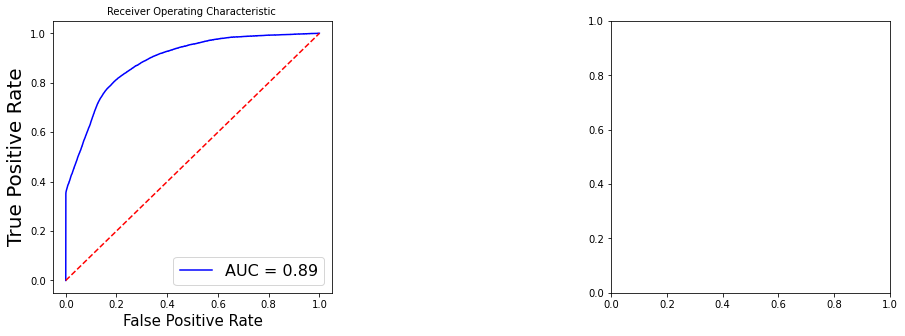

In [ ]:
metric_score('log',X_train,y_train,X_val,y_val)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.8s finished


f1_score: 0.8842156544332576


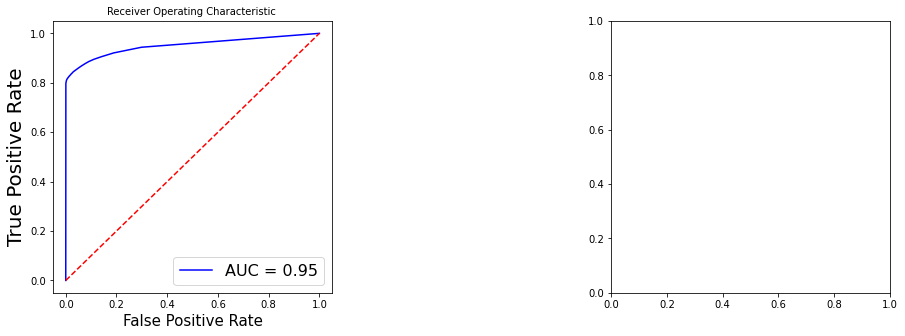

In [ ]:
metric_score('rf',X_train,y_train,X_val,y_val)

f1_score: 0.8835285445163403


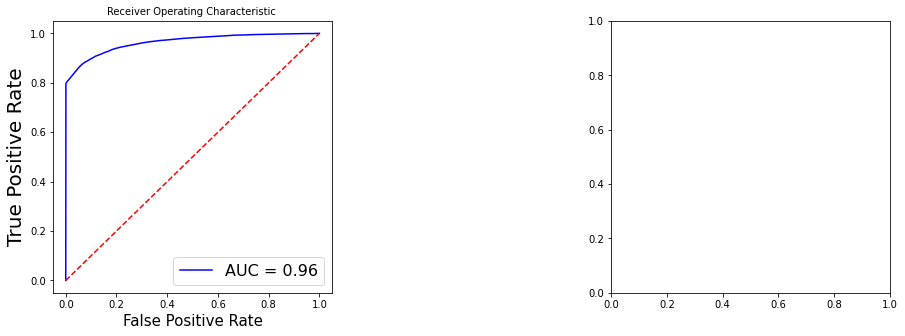

In [ ]:
metric_score('dt',X_train,y_train,X_val,y_val)

f1_score: 0.8464552003032982


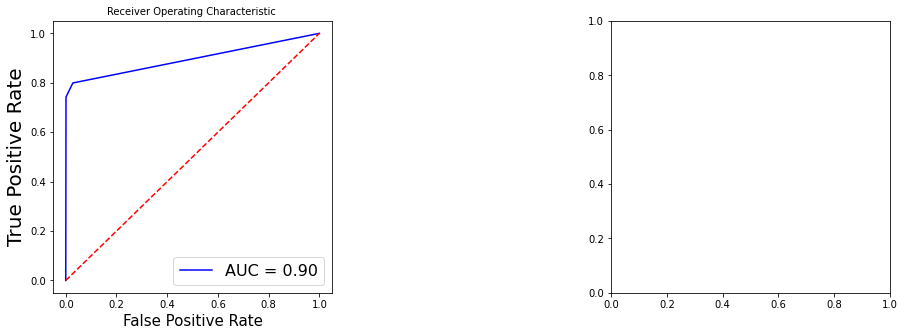

In [ ]:
X_train, X_val = scale_minmax(X_train, X_val)
metric_score('knn',X_train,y_train,X_val,y_val)